# AI Lab Assignment 4

## 2. Building a classifier on a real dataset (5 points)

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate

%matplotlib inline

In [115]:
df = pd.read_csv('./data/german_credit_data.csv', sep=';')
# Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix

print(df.shape)
df.head(5)

(1000, 21)


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [116]:
class_label = 'default'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['account_check_status ', 'duration_in_month ', 'credit_history ', 'purpose ', 'credit_amount ', 'savings ', 'present_emp_since ', 'installment_as_income_perc ', 'personal_status_sex ', 'other_debtors ', 'present_res_since ', 'property ', 'age ', 'other_installment_plans ', 'housing ', 'credits_this_bank ', 'job ', 'people_under_maintenance ', 'telephone ', 'foreign_worker']


**Basic stats for each attribute:**

In [117]:
df.describe()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Numerically encoded data**

In [118]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


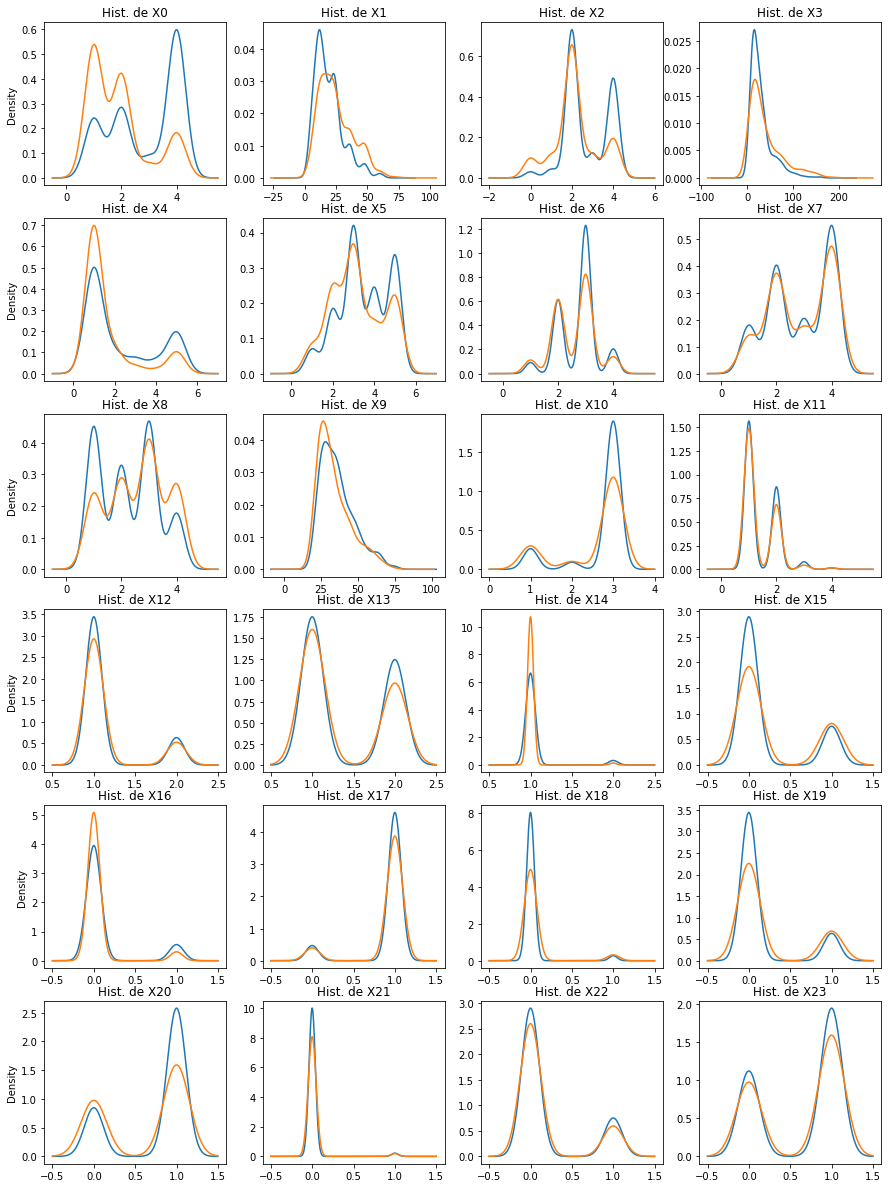

In [119]:
plt.figure(figsize=(15, 21))
n_cols_plot = 4
n_rows_plot = int(len(feature_names) / n_cols_plot)
for i,n in enumerate(feature_names):
    plt.subplot(n_rows_plot, n_cols_plot, i+1)
    aux = 'Density' if i%n_cols_plot == 0 else ''
    df.groupby('Class')[n].plot(kind='kde', title='Hist. de '+n)
    plt.ylabel(aux)

**Smoothed histograms of each attribute in each class. Color indicates class:**

## Training a model and testing its quality using 5-fold cross validation

The following cell trains a model and tests it on several different training-test partitions of the data. The result is a mean score with its standard deviation. The type of model (Naïve Bayes / decision tree / knn / logistic regression / neural network) and parameters used must be selected to obtain the best result.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# other classifiers (from notebook p4_01)

clf = KNeighborsClassifier(n_neighbors=1) # DecisionTreeClassifier(max_depth=3)
scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
print("Accuracy in each cross-validation fold: ", scores)
print("Cross-validation accuracy estimate: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Accuracy in each cross-validation fold:  [0.67 0.64 0.72 0.66 0.64 0.71 0.6  0.71 0.62 0.66]
Cross-validation accuracy estimate: 0.66 +/- 0.04


## Answer the following questions here:

* Plot the dependence of the accuraccy of the k-nn classifier with the number of neighbors. If convenient, use log-scales in the graph axes (`semilogx`, `semilogy`, `loglog`).
* In terms of the concepts of under- and overfitting:
    * Comment the results when the number of neighbours is small.
    * Comment the results when the number of neighbours is large.
    * Explain the meaning of the value of the score when the number of neighbours is as large as possible.
* What is the best accuracy that can be achived with k-nn? For which value of k (`n_neighbours`)?
* What is the best accuracy that can be achived with a decision tree? For which value of the maximum depth  (`max_depth`)? To this end, plot the dependence of the accuraccy of the decision tree with the maximum depth. Comment the results.
* What is the best score you get with a neural network with a single hidden layer? With how many nodes in the hidden layer (value of `hidden_layer_sizes`)? To this end, plot the dependence of the accuraccy of neural with the number of nodes in the hidden layer. Comment the results.
* What is the best score you get with a neural network with several hidden layers? With which configuratuon (value of `hidden_layer_sizes`)? To this end, plot the dependence of the accuraccy of neural with the number of hidden layer, assuming all hidden layers have the same number of nodes. Comment the results.
* Summarize the results and conclusions obtained.

**Besides plots, tables can also be useful to present your results.**


#### Plotting the dependence of the accuraccy of the k-nn classifier with the number of neighbors.

In [9]:
scores_k = []

for i in range(1,50):
    clf = KNeighborsClassifier(n_neighbors=i) # DecisionTreeClassifier(max_depth=3)
    scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
    scores_k.append(scores.mean()*100)

df_table = pd.DataFrame()
df_table['Number of Neighbours']=range(1,50)
df_table['Accuracy'] = scores_k
df_table


,Number of Neighbours,Accuracy
0,1,66.3
1,2,71.2
2,3,68.8
3,4,70.8
4,5,69.0
5,6,70.4
6,7,71.0
7,8,70.5
8,9,70.1
9,10,70.3


Text(0, 0.5, 'Percentage Accuracy')

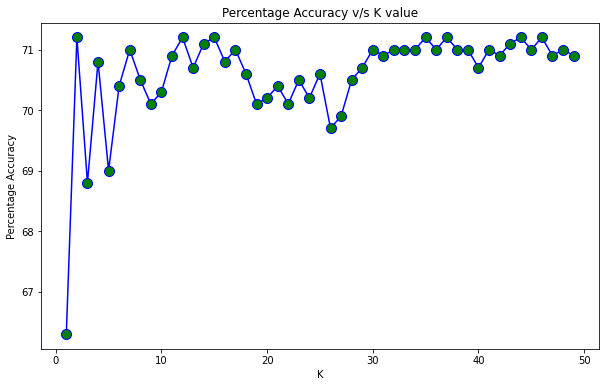

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),scores_k,color='blue',linestyle='solid',marker='o',markerfacecolor='green',markersize=10)
plt.title('Percentage Accuracy v/s K value')
plt.xlabel('K')
plt.ylabel('Percentage Accuracy')

#### Number of neighbours affect on overfitting and underfitting:

A small value of k leads to overfitting while a big value of k can lead to underfitting. We will show this further through code:

In [11]:
train_scores = []
test_scores = []

for i in range(1,50):
    clf = KNeighborsClassifier(n_neighbors=i) # DecisionTreeClassifier(max_depth=3)
    cv_scores = cross_validate(clf, X, y, cv=10,return_train_score=True) # 10-fold cross-validation
    test_scores.append(cv_scores['test_score'].mean())
    train_scores.append(cv_scores['train_score'].mean())


df_table = pd.DataFrame()
df_table['Number of Neighbours']=range(1,50)
df_table['Training Accuracy'] = train_scores
df_table['Test Accuracy'] = test_scores
df_table.head(10)

,Number of Neighbours,Training Accuracy,Test Accuracy
0,1,1.000000,0.663
1,2,0.830111,0.712
2,3,0.830444,0.688
3,4,0.791000,0.708
4,5,0.793667,0.690
5,6,0.768000,0.704
6,7,0.777111,0.710
7,8,0.760000,0.705
8,9,0.766111,0.701
9,10,0.747667,0.703


Text(0, 0.5, 'Train & Test Accuracy')

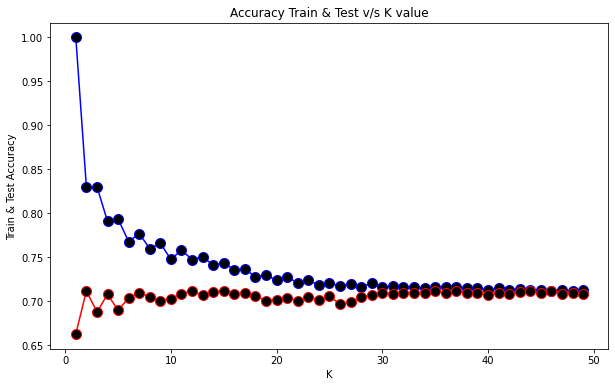

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),train_scores,color='blue',linestyle='solid',marker='o',markerfacecolor='black',markersize=10, label = "Train Score")
plt.plot(range(1,50),test_scores,color='red',linestyle='solid',marker='o',markerfacecolor='black',markersize=10, label = "Test Score")
plt.title('Accuracy Train & Test v/s K value')
plt.xlabel('K')
plt.ylabel('Train & Test Accuracy')

Overfitting implies that a model performs well on training data but poorly when fresh data is introduced. On the other hand, A model is said to be underfitted if it performs poorly on training data and cannot be extended to predict new data.

* Comment the results when the number of neighbours is small/large.

As we can note from the plot, when the number of neighbours is small we have high training data accuracy but relatively poor test data accuracy, hence there is overfitting. On the other hand, when the number of neighbours is large we have both training and test data's accuracy low, hence there is underfitting.

* Explain the meaning of the value of the score when the number of neighbours is as large as possible.

Value of the score is very low when the number of neighbours is as large as possible as the training data's accuracy is decreasing and the test set's is already very low. Hence, there is alot of underfitting. The model is unable to capture the relationship between the input and output variables accurately, generating a high error rate on both the training set and unseen data resulting in a low score.



#### What is the best accuracy that can be achived with k-nn? For which value of k (`n_neighbours`)?



In our opinion, Best accuracy that can be achieved with k-nn will be 71.2% here. It is achieved with a k value of 2,15,35. We will choose a value of k=15 to avoid underfitting and overfitting.

#### What is the best accuracy that can be achived with a decision tree? For which value of the maximum depth  (`max_depth`)? To this end, plot the dependence of the accuraccy of the decision tree with the maximum depth. Comment the results.

In [13]:
scores_md = []

for i in range(1,30):
    clf = DecisionTreeClassifier(criterion='entropy',
                                        max_depth=i)
    scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
    scores_md.append(scores.mean()*100)

df_table = pd.DataFrame()
df_table['Maximum Depth']=range(1,30)
df_table['Accuracy'] = scores_md
df_table

,Maximum Depth,Accuracy
0,1,70.0
1,2,69.6
2,3,72.9
3,4,72.8
4,5,72.3
5,6,73.1
6,7,73.1
7,8,71.7
8,9,71.9
9,10,71.2


Text(0, 0.5, 'Percentage Accuracy')

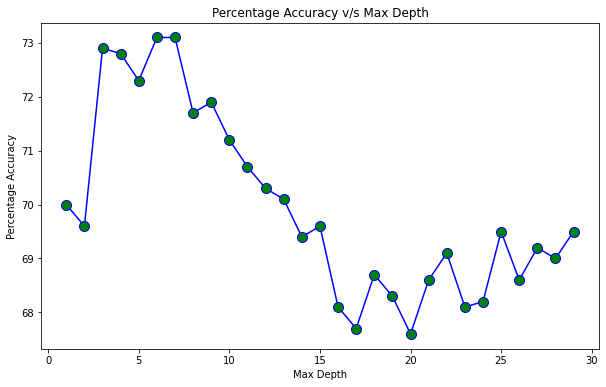

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),scores_md,color='blue',linestyle='solid',marker='o',markerfacecolor='green',markersize=10)
plt.title('Percentage Accuracy v/s Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Percentage Accuracy')

Larger the depth of the tree more are the chances of variance(overfitting). Whereas smaller the depth of the tree more are the chances of bias tree(underfitting).

As we can see that the accuracy is lower for very low values of maximum depth since there is underfitting and also very low for large maximum depth values because of overfitting.

**We can therefore, choose Max Depth = 7 with Accuracy 73.3% as the Best accuracy.**

#### What is the best score you get with a neural network with a single hidden layer? With how many nodes in the hidden layer (value of `hidden_layer_sizes`)? To this end, plot the dependence of the accuraccy of neural with the number of nodes in the hidden layer. Comment the results.

In [15]:
from sklearn.neural_network import MLPClassifier
scores_nn = []

for i in range(1,15):
    clf = MLPClassifier(hidden_layer_sizes=(i,),
                            max_iter=1500,
                            alpha=0.0)
    scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
    scores_nn.append(scores.mean()*100)

df_table = pd.DataFrame()
df_table['Number of Nodes']=range(1,15)
df_table['Accuracy'] = scores_nn
df_table

,Number of Nodes,Accuracy
0,1,70.5
1,2,71.2
2,3,75.2
3,4,76.4
4,5,76.5
5,6,74.9
6,7,75.8
7,8,76.3
8,9,76.5
9,10,77.4


Text(0, 0.5, 'Percentage Accuracy')

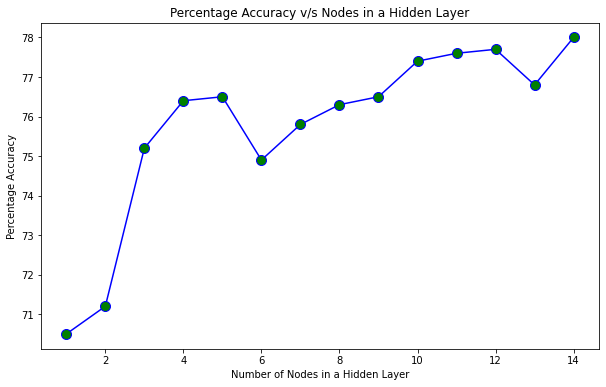

In [16]:
plt.figure(figsize=(10,6))
plt.plot(range(1,15),scores_nn,color='blue',linestyle='solid',marker='o',markerfacecolor='green',markersize=10)
plt.title('Percentage Accuracy v/s Nodes in a Hidden Layer')
plt.xlabel('Number of Nodes in a Hidden Layer')
plt.ylabel('Percentage Accuracy')

Too many neurons in the hidden layers may also result in overfitting. It is therefore ideal to find the optimal number of hidden layers and neurons through testing.

**In our case, choose Number of Nodes as 8 with Accuracy 76.9% as the Best accuracy.**

#### What is the best score you get with a neural network with several hidden layers? With which configuratuon (value of `hidden_layer_sizes`)? To this end, plot the dependence of the accuraccy of neural with the number of hidden layer, assuming all hidden layers have the same number of nodes. Comment the results.

In [17]:
from sklearn.neural_network import MLPClassifier
scores_hnn = []

node_constant = 10
layers = []

for i in range(1,10):
    layers.append(node_constant)
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                            max_iter=1000,
                            alpha=0.0)
    scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
    scores_hnn.append(scores.mean()*100)

df_table = pd.DataFrame()
df_table['Number of Nodes']=range(1,10)
df_table['Accuracy'] = scores_hnn
df_table

,Number of Nodes,Accuracy
0,1,77.7
1,2,76.3
2,3,76.6
3,4,76.3
4,5,76.4
5,6,75.8
6,7,77.2
7,8,76.4
8,9,77.2


Text(0, 0.5, 'Percentage Accuracy')

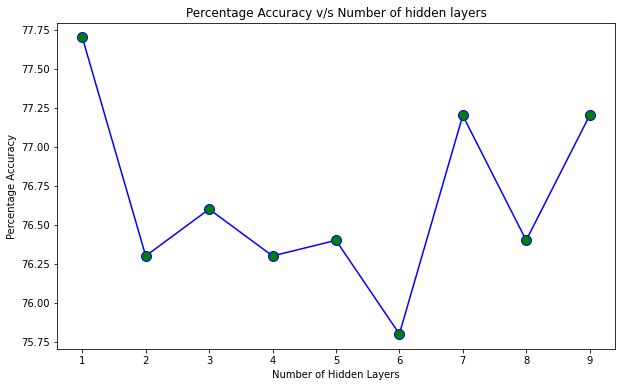

In [18]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),scores_hnn,color='blue',linestyle='solid',marker='o',markerfacecolor='green',markersize=10)
plt.title('Percentage Accuracy v/s Number of hidden layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Percentage Accuracy')

Increasing the number of hidden layers may or may not increase accuracy depending on the complexity of the problem being solved. Yes, accuracy in the test set will drop when the number of hidden layers is increased beyond the necessary number due to overfitting. 

**In our case, choose Number of Hidden Layers as 3 with Accuracy 78.3% as the Best accuracy.**

#### Summarize the results and conclusions obtained.

We have examined how to achieve a balance between underfitting and overfitting by tweaking the hyperparameters in each classification model. We have realised that:
* For KNN            : Low K         --> Overfitting , High K        --> Underfitting.
* For Decision Trees : Low MaxDepth  --> Underfitting, High MaxDepth --> Overfitting.
* For Neural Networks: Low Nodes     --> Underfitting, High Nodes    --> Overfitting. Low Layers    --> Underfitting, High Layers   --> Overfitting. 

## Improve the model: feature processing and parameter search

Sometimes, instead of using more complex models, it is more useful to spend more time processing the data to get better results.

In this section you will investigate a few approaches for preparing the data which are likely to improve the results: feature construction and selection, feature preprocessing (detection of outliers, missing values, centering and scaling).

Give reasons why you decide to use or discard these methods, and how the results change when you apply them.
Use tables, graphs, and code, as needed, to illustrate your observations.

In [102]:
pp_df = pd.read_csv('./data/german_credit_data.csv', sep=';')
# Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix
pp_df.head(5)

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


### Feature preprocessing:

In [103]:
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   default                      1000 non-null   int64 
 1   account_check_status         1000 non-null   object
 2   duration_in_month            1000 non-null   int64 
 3   credit_history               1000 non-null   object
 4   purpose                      1000 non-null   object
 5   credit_amount                1000 non-null   int64 
 6   savings                      1000 non-null   object
 7   present_emp_since            1000 non-null   object
 8   installment_as_income_perc   1000 non-null   int64 
 9   personal_status_sex          1000 non-null   object
 10  other_debtors                1000 non-null   object
 11  present_res_since            1000 non-null   int64 
 12  property                     1000 non-null   object
 13  age                          1000 

* We dont see any null values
* 3 data types (Object, Float and Integers) are present
* Categorical variables : 13
* Numerical variables (Float and Integer) : 8
* Target variable: customer_type - Integer

#### Handling of Missing Values:

In [120]:
#Checking how many missing values are in each variable column
round(df.isnull().sum() / df.isnull().count() * 100, 2)

X0       0.0
X1       0.0
X2       0.0
X3       0.0
X4       0.0
X5       0.0
X6       0.0
X7       0.0
X8       0.0
X9       0.0
X10      0.0
X11      0.0
X12      0.0
X13      0.0
X14      0.0
X15      0.0
X16      0.0
X17      0.0
X18      0.0
X19      0.0
X20      0.0
X21      0.0
X22      0.0
X23      0.0
Class    0.0
dtype: float64

#### Outlier Detection:

In [121]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X0,1000.0,2.577,1.257638,1.0,1.0,2.0,4.0,4.0
X1,1000.0,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
X2,1000.0,2.545,1.083120,0.0,2.0,2.0,4.0,4.0
X3,1000.0,32.711,28.252605,2.0,14.0,23.0,40.0,184.0
X4,1000.0,2.105,1.580023,1.0,1.0,1.0,3.0,5.0
X5,1000.0,3.384,1.208306,1.0,3.0,3.0,5.0,5.0
X6,1000.0,2.682,0.708080,1.0,2.0,3.0,3.0,4.0
X7,1000.0,2.845,1.103718,1.0,2.0,3.0,4.0,4.0
X8,1000.0,2.358,1.050209,1.0,1.0,2.0,3.0,4.0
X9,1000.0,35.546,11.375469,19.0,27.0,33.0,42.0,75.0


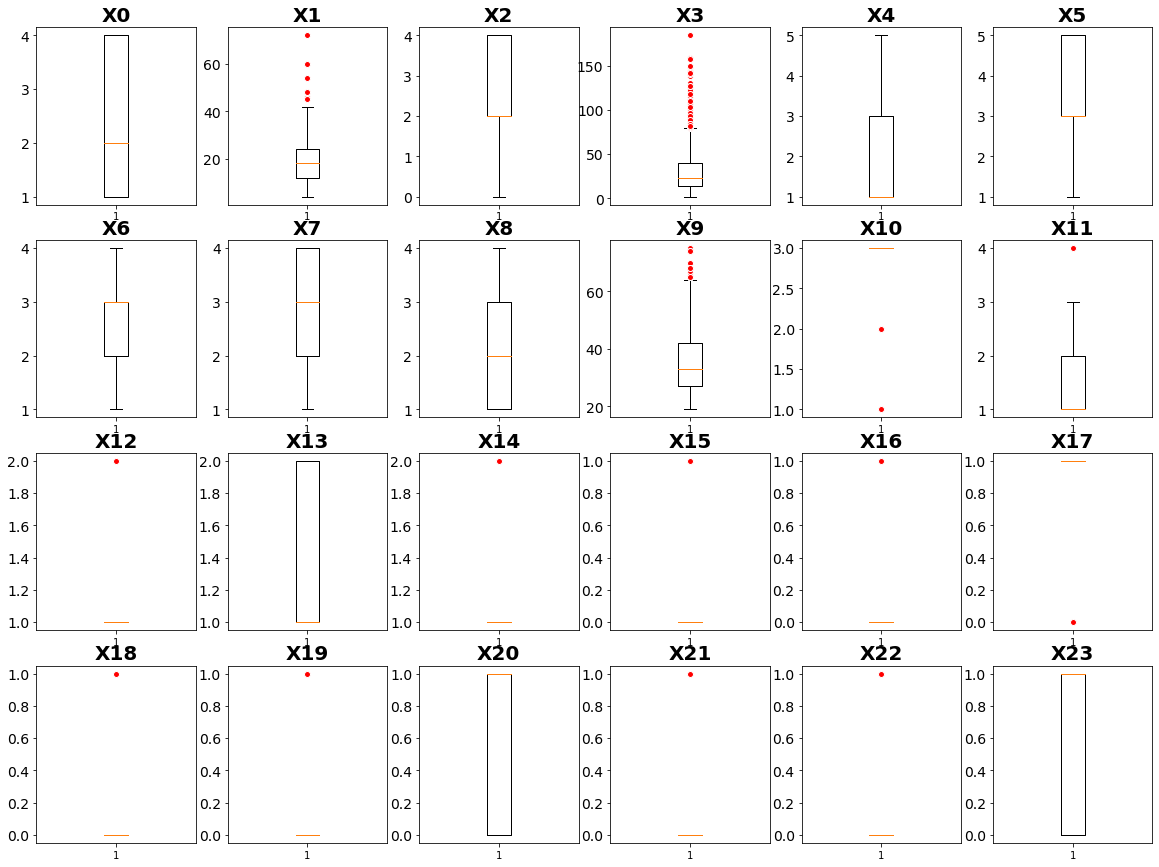

In [132]:
#Creating subplot of each column with its own scale
def create_boxplots(df,feature_names):
    red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
    plt.figure(figsize=(20, 15))
    n_cols_plot = 6
    n_rows_plot = int(len(feature_names) / n_cols_plot)
    for i,n in enumerate(feature_names):
        ax = plt.subplot(n_rows_plot, n_cols_plot, i+1)
        ax.boxplot(df[feature_names[i]], flierprops=red_circle)
        ax.set_title(feature_names[i], fontsize=20, fontweight='bold')
        ax.tick_params(axis='y', labelsize=14)

create_boxplots(df, feature_names)

**We can note here that only X1, X3, X9 are numerical continuous values with outliers.**

#### Outlier Removal:

In [135]:
def REM_OUTLIERS(df,col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1 #Interquartile range
    MIN  = Q1 - 1.5 * IQR
    MAX =  Q3 + 1.5 * IQR
    df_out = df.loc[(df[col_name] > MIN) & (df[col_name] < MAX)]
    return df_out
    
outlier_variables = ["X1","X3","X9"] #["duration_in_month ", "credit_amount ", "age "]
for i in outlier_variables:
    processed_df = REM_OUTLIERS(df,i)

processed_df.shape



(977, 25)

#### Scaling And Centering of Data:

In [142]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled_df = ss.fit_transform(processed_df)
scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
X0,977.0,8.363604e-17,1.000512,-1.259920,-1.259920,-0.465251,1.124086,1.124086
X1,977.0,3.636350e-18,1.000512,-1.410567,-0.748485,-0.251923,0.244638,4.217131
X2,977.0,1.654539e-16,1.000512,-2.343957,-0.494909,-0.494909,1.354139,1.354139
X3,977.0,5.999977e-17,1.000512,-1.091933,-0.665462,-0.345608,0.258560,5.376221
X4,977.0,-4.772709e-17,1.000512,-0.701649,-0.701649,-0.701649,0.564299,1.830248
X5,977.0,-1.472722e-16,1.000512,-2.004058,-0.329152,-0.329152,1.345753,1.345753
X6,977.0,9.090874e-18,1.000512,-2.357901,-0.954936,0.448030,0.448030,1.850995
X7,977.0,-5.454525e-17,1.000512,-1.655618,-0.749434,0.156750,1.062934,1.062934
X8,977.0,-1.281813e-16,1.000512,-1.299537,-1.299537,-0.341312,0.616912,1.575137
X9,977.0,3.199988e-16,1.000512,-1.533147,-0.755378,-0.172052,0.605716,2.841799


#### Feature Selection:

Text(0.5, 1.0, 'Correlation of Parameters with Class')

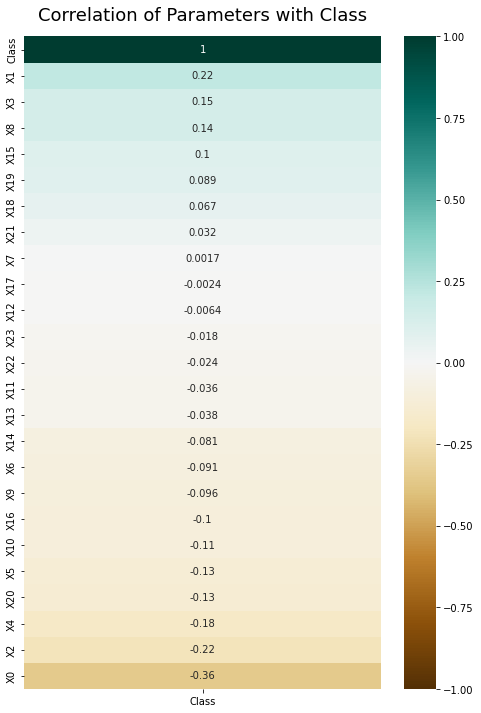

In [143]:
import seaborn as sns
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(scaled_df.corr()[['Class']].sort_values(by='Class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation of Parameters with Class', fontdict={'fontsize':18}, pad=16)

**Now we can note that the top 5 most correlated/important features are: X0, X1, X2, X4, X5.**

## How does one determines the value of the hyperparameters?

To determine the value of the huperparameters, one carries out a grid search:
The values that maximize the cross-validation estimate of the predictor's accuracy are selected.

Adapt the code in 
[https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)
and determine the hyperparameters for each of the classifiers considered.

The tutorials
[https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](
    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
[https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
provide useful information on the meaning of the hyperparameters. 
You may chose which hyperparameters need to be optimized. 
Before specifing the hyperparameter grid, make sure that you understand each of the hyperparameters explored so that the values considered are reasonable.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [22]:
from sklearn.model_selection import GridSearchCV
import numpy as np

#Optimizing for Number of Neighbors Hyperparameter only.
#Rest of the hyperparameters are kept default
tuned_parameters_knn = [
    {"n_neighbors": np.arange(1, 30, 2)},
]

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_parameters_knn, cv=10)
knn_grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(knn_grid.best_score_))
print("best parameters:", knn_grid.best_params_)
print("test-set score: {:.3f}".format(knn_grid.score(X_test, y_test)))

best mean cross-validation score: 0.716
best parameters: {'n_neighbors': 23}
test-set score: 0.708


In [23]:
#Optimizing for the criterion and max Depth Hyperparameter only.
#Rest of the hyperparameters are kept default
tuned_parameters_decision_trees = tree_para = {'criterion':['gini','entropy'],'max_depth':[3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,100]}

dt_grid = GridSearchCV( DecisionTreeClassifier(), param_grid=tuned_parameters_decision_trees, cv=10)
dt_grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(dt_grid.best_score_))
print("best parameters:", dt_grid.best_params_)
print("test-set score: {:.3f}".format(dt_grid.score(X_test, y_test)))

best mean cross-validation score: 0.784
best parameters: {'criterion': 'gini', 'max_depth': 7}
test-set score: 0.708


In [24]:
#Optimizing for the max_iter,alpha and neuron configuration Hyperparameter only.
#Rest of the hyperparameters are kept default
tuned_parameters_mlp = {
    'hidden_layer_sizes': [(10,30,10),(20,),(20,20,20),(50,10),(50,)],
    'alpha': [0.0001, 0.05],
    'max_iter': [1500,2000,2500,3000]
}

grid = GridSearchCV( MLPClassifier(), param_grid=tuned_parameters_mlp, cv=10)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters:", grid.best_params_)
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.795
best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'max_iter': 1500}
test-set score: 0.756


## ¿How does one estimate the generalization error?

To estimate the generalization error, we will use *Nested Cross Validation*. 


Adapt the code in [https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) para resolver este problema con una red neuronal.

In [25]:
from sklearn.model_selection import cross_validate
# Your code here
def do_cross_validation(clf, print_model=False):
    cv = cross_validate(clf, X, y, scoring='accuracy', cv=3)
    scores = ' + '.join(f'{s:.2f}' for s in cv["test_score"])
    mean_ = cv["test_score"].mean()
    msg = f'Cross-validated accuracy: ({scores}) / 3 = {mean_:.2f}'
    
    if print_model:
        msg = f'{clf}:\n\t{msg}\n'
    
    print(msg)


In [26]:
do_cross_validation(knn_grid, print_model=True)
do_cross_validation(dt_grid, print_model=True)
do_cross_validation(grid, print_model=True)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])}]):
	Cross-validated accuracy: (0.69 + 0.70 + 0.72) / 3 = 0.71

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20,
                                       30, 40, 50, 100]}):
	Cross-validated accuracy: (0.75 + 0.69 + 0.76) / 3 = 0.73

GridSearchCV(cv=10, estimator=MLPClassifier(),
             param_grid={'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,),
                                                (20, 20, 20), (50, 10), (50,)],
                         'max_iter': [1500, 2000, 2500, 3000]}):
	Cross-validated accuracy: (0.77 + 0.76 + 0.78) / 3 = 0.77



## Which is the best classifier?

* According to the results of previous of the previous cells, what is the best classifier you have found?
* What are the values of the hyparameters used to configure and train such classifier?
* What are the parameters of the trained classifier?
* Provide an estimate of the generalization error and its uncertainty using cross-validation.

Based on the last part's generalization errors using *Nested Cross Validation*, We can confidently pick the Multi-layer Perceptron(MLP) classifier as our winner model. It has the highest cross-validated accuracy of 0.77.

In [27]:
print("The hyperparameters used to configure the best classifier of MLP are: ", grid.best_params_)

The hyperparameters used to configure the best classifier of MLP are:  {'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'max_iter': 1500}


In [28]:
grid.get_params(deep=True)

{'cv': 10,
 'error_score': nan,
 'estimator__activation': 'relu',
 'estimator__alpha': 0.0001,
 'estimator__batch_size': 'auto',
 'estimator__beta_1': 0.9,
 'estimator__beta_2': 0.999,
 'estimator__early_stopping': False,
 'estimator__epsilon': 1e-08,
 'estimator__hidden_layer_sizes': (100,),
 'estimator__learning_rate': 'constant',
 'estimator__learning_rate_init': 0.001,
 'estimator__max_fun': 15000,
 'estimator__max_iter': 200,
 'estimator__momentum': 0.9,
 'estimator__n_iter_no_change': 10,
 'estimator__nesterovs_momentum': True,
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__solver': 'adam',
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': False,
 'estimator__warm_start': False,
 'estimator': MLPClassifier(),
 'n_jobs': None,
 'param_grid': {'hidden_layer_sizes': [(10, 30, 10),
   (20,),
   (20, 20, 20),
   (50, 10),
   (50,)],
  'alpha': [0.0001, 0.05],
  'max_iter': [1500, 2000, 250

The MLP Model, using nested cross-validation, has a mean accuracy of 0.77. 

In [29]:
clf = MLPClassifier(hidden_layer_sizes=(50, 10),
                            max_iter=1500,
                            alpha=0.0001)
scores = cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
print("Accuracy in each cross-validation fold: ", scores)
print("Cross-validation accuracy estimate: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Accuracy in each cross-validation fold:  [0.79 0.7  0.8  0.81 0.73 0.81 0.69 0.83 0.72 0.76]
Cross-validation accuracy estimate: 0.76 +/- 0.05


## Conclusions
**Summarize the results and conclusions of your study.**

In this part, Using a real dataset we are testing different classifiers such as MLP,Decision Trees, KNN, to obtain the best one. We first analyze the affects of the change in hyperparameters in each classifier towards the model(under/overfitting). Furthermore, We conclude the initial part by learning how to find the best hyperparameter by manually checking scores for different values. Generally too high or too low values give us overfitting or underitting hence, a nice balance is required depending on the complexity of the model. We showcase this by the use of graphs and tables.



Secondly, By making use of data-preprocessing we manage to improve the results of the models significantly and make use of grid search to find the best hyperparameters for each of the classifiers. We then estimate the generalization error and choose the best classifier based on it.